In [1]:
import pandas as pd
import requests
from itertools import chain
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import glob
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import math

In [2]:
df = pd.read_stata('alphafold_ls_24.dta')

In [3]:
b24 = df[df['balanced_24']==1]
b12 = df[df['balanced_12']==1]

In [100]:
obs = df.groupby('id')['months_from_treatment'].agg({'min','max'})

In [176]:
b24 = df[df['id'].isin(obs[(obs['max']>=24) & (obs['min']<=-24)].index)]

In [177]:
b12 = df[df['id'].isin(obs[(obs['max']>=12) & (obs['min']<=-12)].index)]

In [178]:
b12 = b12[(b12['months_from_treatment'] >= -12) & (b12['months_from_treatment'] <= 12)]

In [119]:
for column in b12.columns:
    print("'"+column+"'", end=", ")

'index', 'id', 'publication_month', 'count', 'af_count', '_2023_JIF_sum', '_5_Year_JIF_sum', 'Immediacy_Index_sum', '_2023_JCI_sum', 'Eigenfactor_sum', 'Normalized_Eigenfactor_sum', 'Article_Influence_Score_sum', 'authors_count_sum', 'countries_distinct_count_sum', 'institutions_distinct_count_sum', 'treatment_month', 'is_ls', 'is_ls_first', 'is_ls_last', 'start_month', 'end_month', 'topic_max', 'subfield_max', 'field_max', 'domain_max', 'topic_hhi_total', 'subfield_hhi_total', 'field_hhi_total', 'domain_hhi_total', 'topics_unique', 'subfields_unique', 'fields_unique', 'domains_unique', 'topics_unique_3', 'subfields_unique_3', 'fields_unique_3', 'domains_unique_3', 'topics_unique_6', 'subfields_unique_6', 'fields_unique_6', 'domains_unique_6', 'topics_unique_12', 'subfields_unique_12', 'fields_unique_12', 'domains_unique_12', 'topics_hhi_3', 'topics_hhi_6', 'topics_hhi_12', 'subfields_hhi_3', 'subfields_hhi_6', 'subfields_hhi_12', 'fields_hhi_3', 'fields_hhi_6', 'fields_hhi_12', 'domai

In [179]:
b12 = b12.drop(columns={'_5_Year_JIF_sum','Immediacy_Index_sum','_2023_JCI_sum','Eigenfactor_sum','Normalized_Eigenfactor_sum', 'Article_Influence_Score_sum', 'authors_count_sum', 'countries_distinct_count_sum', 'institutions_distinct_count_sum','topics_unique_3', 'subfields_unique_3', 'fields_unique_3', 'domains_unique_3', 'topics_unique_6', 'subfields_unique_6', 'fields_unique_6', 'domains_unique_6','topics_hhi_3', 'topics_hhi_6','subfields_hhi_3', 'subfields_hhi_6','fields_hhi_3', 'fields_hhi_6','domains_hhi_3', 'domains_hhi_6','count_3', 'count_6','af_count_3', 'af_count_6', 'af_count_12', '_2023_JIF_sum_3', '_2023_JIF_sum_6', '_5_Year_JIF_sum_3', '_5_Year_JIF_sum_6', '_5_Year_JIF_sum_12', 'Immediacy_Index_sum_3', 'Immediacy_Index_sum_6', 'Immediacy_Index_sum_12', '_2023_JCI_sum_3', '_2023_JCI_sum_6', '_2023_JCI_sum_12', 'Eigenfactor_sum_3', 'Eigenfactor_sum_6', 'Eigenfactor_sum_12', 'Normalized_Eigenfactor_sum_3', 'Normalized_Eigenfactor_sum_6', 'Normalized_Eigenfactor_sum_12', 'Article_Influence_Score_sum_3', 'Article_Influence_Score_sum_6', 'Article_Influence_Score_sum_12', 'authors_count_sum_3', 'authors_count_sum_6', 'authors_count_sum_12', 'countries_distinct_count_sum_3', 'countries_distinct_count_sum_6', 'countries_distinct_count_sum_12', 'institutions_distinct_count_sum_', '_0institutions_distinct_count_su', '_1institutions_distinct_count_su'})
                        

In [180]:
b24 = b24.drop(columns={'_5_Year_JIF_sum','Immediacy_Index_sum','_2023_JCI_sum','Eigenfactor_sum','Normalized_Eigenfactor_sum', 'Article_Influence_Score_sum', 'authors_count_sum', 'countries_distinct_count_sum', 'institutions_distinct_count_sum','topics_unique_3', 'subfields_unique_3', 'fields_unique_3', 'domains_unique_3', 'topics_unique_6', 'subfields_unique_6', 'fields_unique_6', 'domains_unique_6','topics_hhi_3', 'topics_hhi_6','subfields_hhi_3', 'subfields_hhi_6','fields_hhi_3', 'fields_hhi_6','domains_hhi_3', 'domains_hhi_6','count_3', 'count_6','af_count_3', 'af_count_6', 'af_count_12', '_2023_JIF_sum_3', '_2023_JIF_sum_6', '_5_Year_JIF_sum_3', '_5_Year_JIF_sum_6', '_5_Year_JIF_sum_12', 'Immediacy_Index_sum_3', 'Immediacy_Index_sum_6', 'Immediacy_Index_sum_12', '_2023_JCI_sum_3', '_2023_JCI_sum_6', '_2023_JCI_sum_12', 'Eigenfactor_sum_3', 'Eigenfactor_sum_6', 'Eigenfactor_sum_12', 'Normalized_Eigenfactor_sum_3', 'Normalized_Eigenfactor_sum_6', 'Normalized_Eigenfactor_sum_12', 'Article_Influence_Score_sum_3', 'Article_Influence_Score_sum_6', 'Article_Influence_Score_sum_12', 'authors_count_sum_3', 'authors_count_sum_6', 'authors_count_sum_12', 'countries_distinct_count_sum_3', 'countries_distinct_count_sum_6', 'countries_distinct_count_sum_12', 'institutions_distinct_count_sum_', '_0institutions_distinct_count_su', '_1institutions_distinct_count_su'})                        

In [186]:
before_24 = b24[b24['months_from_treatment']==-1]

In [187]:
before_24 = before_24[['id','tmonth','cum_count','months_from_start','count_12']]

In [188]:
before_24 = before_24.rename(columns={'cum_count':'pubs_before_treatment','months_from_start':'months_before_treatment','count_12':'productivity_before_treatment'})

In [189]:
for column in before_24.columns:
    if column=='id': continue
    before_24[f'{column}_demean'] = before_24[column] - before_24[column].mean()
    before_24[f'{column}_medsplit'] = pd.qcut(before_24[column],2, labels=[0,1])
    before_24[f'{column}_tertile'] = pd.qcut(before_24[column],3, labels=[0,1,2])

In [191]:
before_24 = before_24.drop(columns={'tmonth'})

In [194]:
b24 = b24.merge(before_24,on='id',how='left')

In [195]:
before_12 = b12[b12['months_from_treatment']==-1]

In [196]:
before_12 = before_12[['id','tmonth','cum_count','months_from_start','count_12']]

In [197]:
before_12 = before_12.rename(columns={'cum_count':'pubs_before_treatment','months_from_start':'months_before_treatment','count_12':'productivity_before_treatment'})

In [198]:
for column in before_12.columns:
    if column=='id': continue
    before_12[f'{column}_demean'] = before_12[column] - before_12[column].mean()
    before_12[f'{column}_medsplit'] = pd.qcut(before_12[column],2, labels=[0,1])
    before_12[f'{column}_tertile'] = pd.qcut(before_12[column],3, labels=[0,1,2])

In [199]:
before_12 = before_12.drop(columns={'tmonth'})

In [200]:
b12 = b12.merge(before_12,on='id',how='left').

In [201]:
b12

,index,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,...,tmonth_tertile,pubs_before_treatment_demean,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_demean,productivity_before_treatment_medsplit,productivity_before_treatment_tertile
0,26640,https://openalex.org/A5000001503,2021-01-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
1,26641,https://openalex.org/A5000001503,2021-02-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
2,26642,https://openalex.org/A5000001503,2021-03-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
3,26643,https://openalex.org/A5000001503,2021-04-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
4,26644,https://openalex.org/A5000001503,2021-05-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386131,6994982,https://openalex.org/A5104977687,2023-07-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0
386132,6994983,https://openalex.org/A5104977687,2023-08-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0
386133,6994984,https://openalex.org/A5104977687,2023-09-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0
386134,6994985,https://openalex.org/A5104977687,2023-10-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0


In [10]:
b12.to_stata('b12.dta', version=118)

In [204]:
b24.to_stata('b24.dta', version=118)

/state/partition1/job-50919294/ipykernel_352309/42328843.py:1: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    productivity_before_treatment_demean   ->   productivity_before_treatment_de
    productivity_before_treatment_medsplit   ->   productivity_before_treatment_me
    productivity_before_treatment_tertile   ->   productivity_before_treatment_te

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  b24.to_stata('b24.dta', version=118)
/state/partition1/job-50919294/ipykernel_352309/42328843.py:1: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column tmonth_medsplit contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels

In [2]:
b12 = pd.read_stata('b12.dta')

In [3]:
b12 = b12.drop(columns={'level_0','index'})

In [4]:
b12

,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,start_month,...,tmonth_tertile,pubs_before_treatment_demean,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te
0,https://openalex.org/A5000001503,2021-01-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
1,https://openalex.org/A5000001503,2021-02-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
2,https://openalex.org/A5000001503,2021-03-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
3,https://openalex.org/A5000001503,2021-04-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
4,https://openalex.org/A5000001503,2021-05-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386131,https://openalex.org/A5104977687,2023-07-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0
386132,https://openalex.org/A5104977687,2023-08-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0
386133,https://openalex.org/A5104977687,2023-09-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0
386134,https://openalex.org/A5104977687,2023-10-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,1,-32.822674,0,0,105.850146,1,2,-0.395032,0,0


In [9]:
b12['id_numeric'] = b12['id_numeric'].astype(int)

In [10]:
before_12 = b12[b12['months_from_treatment']==-1]

In [11]:
before_12

,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,start_month,...,tmonth_tertile,pubs_before_treatment_demean,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te
11,https://openalex.org/A5000001503,2021-12-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
35,https://openalex.org/A5000018755,2022-11-01,0.0,0.0,0.0,2022-12-01,1,0,0,2015-02-01,...,1,-28.822674,0,0,-150.149854,0,0,-0.311698,0,0
59,https://openalex.org/A5000022218,2023-05-01,0.0,0.0,0.0,2023-06-01,1,0,1,2003-01-01,...,2,-20.822674,0,1,0.850146,1,1,-0.478365,0,0
83,https://openalex.org/A5000031273,2022-08-01,0.0,0.0,0.0,2022-09-01,1,0,0,1981-02-01,...,1,1.177326,1,2,254.850146,1,2,-0.311698,0,0
107,https://openalex.org/A5000037407,2022-03-01,0.0,0.0,0.0,2022-04-01,1,1,1,1998-04-01,...,0,-3.822674,1,1,43.850146,1,1,-0.061698,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386027,https://openalex.org/A5104336056,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,2020-01-01,...,2,-33.822674,0,0,-208.149854,0,0,-0.478365,0,0
386051,https://openalex.org/A5104355009,2022-08-01,0.0,0.0,0.0,2022-09-01,1,0,0,1992-11-01,...,1,-11.822674,1,1,113.850146,1,2,-0.478365,0,0
386075,https://openalex.org/A5104385600,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,1980-10-01,...,2,12.177326,1,2,262.850146,1,2,0.021635,1,1
386099,https://openalex.org/A5104670207,2023-01-01,1.0,0.0,2.3,2023-02-01,1,0,0,2013-02-01,...,2,-4.822674,1,1,-124.149854,0,0,0.188302,1,2


In [13]:
for column in before_12.columns:
    print(column)

id
publication_month
count
af_count
_2023_JIF_sum
treatment_month
is_ls
is_ls_first
is_ls_last
start_month
end_month
topic_max
subfield_max
field_max
domain_max
topic_hhi_total
subfield_hhi_total
field_hhi_total
domain_hhi_total
topics_unique
subfields_unique
fields_unique
domains_unique
topics_unique_12
subfields_unique_12
fields_unique_12
domains_unique_12
topics_hhi_12
subfields_hhi_12
fields_hhi_12
domains_hhi_12
count_12
_2023_JIF_sum_12
id_numeric
months_from_treatment
max_monthly_pubs
tenure
works_count
fuzzy_matched_name_count
months_from_start
pre_obs
post_obs
post
time24_0
time24_1
time24_2
time24_3
time24_4
time24_5
time24_6
time24_7
time24_8
time24_9
time24_10
time24_11
time24_12
time24_13
time24_14
time24_15
time24_16
time24_17
time24_18
time24_19
time24_20
time24_21
time24_22
time24_23
time24_24
time24_25
time24_26
time24_27
time24_28
time24_29
time24_30
time24_31
time24_32
time24_33
time24_34
time24_35
time24_36
time24_37
time24_38
time24_39
time24_40
time24_41
time24_42

In [22]:
before_12['is_ls_med'] = ((before_12['is_ls_first']==0) & (before_12['is_ls_last']==0)).astype(int)

/state/partition1/job-51259568/ipykernel_4194185/3771006126.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  before_12['is_ls_med'] = ((before_12['is_ls_first']==0) & (before_12['is_ls_last']==0)).astype(int)
/state/partition1/job-51259568/ipykernel_4194185/3771006126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_12['is_ls_med'] = ((before_12['is_ls_first']==0) & (before_12['is_ls_last']==0)).astype(int)


In [43]:
corr_matrix = before_12[['is_ls_first','is_ls_med','is_ls_last','pubs_before_treatment_demean','months_before_treatment_demean','productivity_before_treatment_de','treatment_month']].corr()

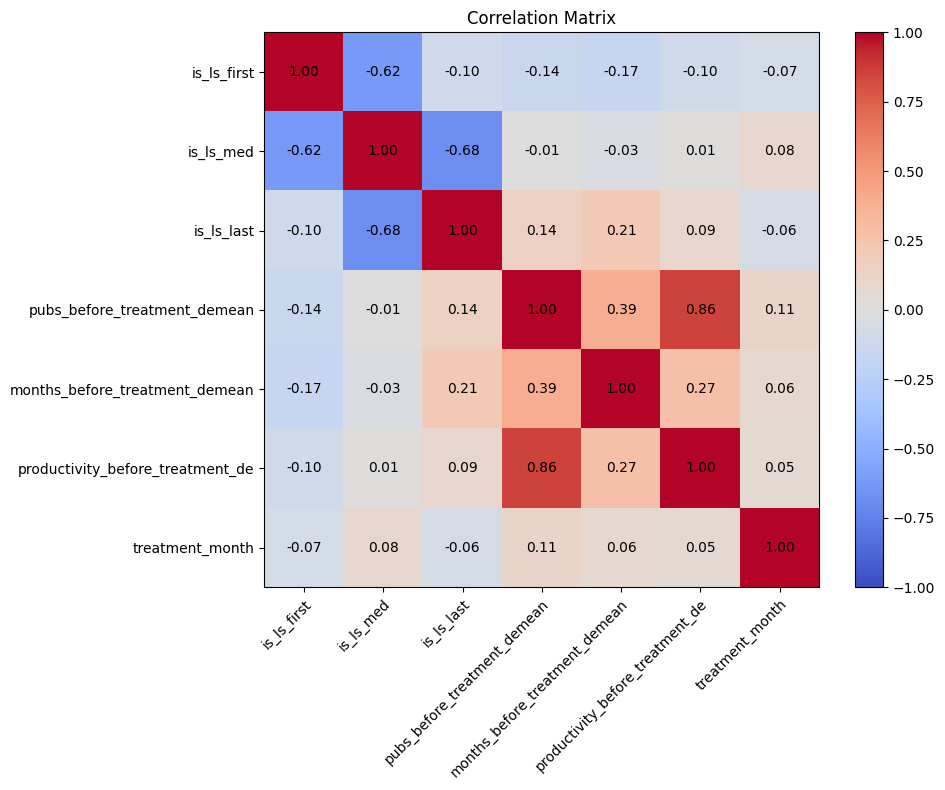

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax.set_title("Correlation Matrix")
fig.tight_layout()
plt.show()

In [33]:
before_12['treatment_month']

11       2022-01-01
35       2022-12-01
59       2023-06-01
83       2022-09-01
107      2022-04-01
            ...    
386027   2023-01-01
386051   2022-09-01
386075   2023-01-01
386099   2023-02-01
386123   2022-11-01
Name: treatment_month, Length: 16089, dtype: datetime64[ns]

In [45]:
before_12[['pubs_before_treatment','months_before_treatment','productivity_before_treatment']].describe()

,pubs_before_treatment,months_before_treatment,productivity_before_treatment
count,16089.000000,16089.000000,16089.000000
mean,35.822674,243.149854,0.478365
std,41.353096,139.198784,0.602521
min,1.000000,11.000000,0.000000
25%,10.000000,129.000000,0.083333
50%,23.000000,236.000000,0.250000
75%,46.000000,342.000000,0.583333
max,505.000000,596.000000,9.250000


In [53]:
before_12[before_12['pubs_before_treatment_medsplit']=='0'][['pubs_before_treatment','months_before_treatment','productivity_before_treatment']].describe()

,pubs_before_treatment,months_before_treatment,productivity_before_treatment
count,8282.000000,8282.000000,8282.000000
mean,10.913426,185.081744,0.172261
std,6.365711,134.793413,0.164552
min,1.000000,11.000000,0.000000
25%,5.000000,75.000000,0.083333
50%,10.000000,154.000000,0.166667
75%,16.000000,268.000000,0.250000
max,23.000000,595.000000,1.500000


In [52]:
before_12[before_12['pubs_before_treatment_medsplit']=='0']

,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,start_month,...,pubs_before_treatment_demean,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te,is_ls_med
11,https://openalex.org/A5000001503,2021-12-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,-30.822674,0,0,175.850146,1,2,-0.311698,0,0,1
35,https://openalex.org/A5000018755,2022-11-01,0.0,0.0,0.0,2022-12-01,1,0,0,2015-02-01,...,-28.822674,0,0,-150.149854,0,0,-0.311698,0,0,1
59,https://openalex.org/A5000022218,2023-05-01,0.0,0.0,0.0,2023-06-01,1,0,1,2003-01-01,...,-20.822674,0,1,0.850146,1,1,-0.478365,0,0,0
131,https://openalex.org/A5000049746,2023-03-01,0.0,0.0,0.0,2023-04-01,1,0,0,1998-07-01,...,-25.822674,0,0,52.850146,1,1,-0.228365,0,1,1
179,https://openalex.org/A5000055042,2022-12-01,0.0,0.0,0.0,2023-01-01,1,1,0,2020-11-01,...,-33.822674,0,0,-218.149854,0,0,-0.478365,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385931,https://openalex.org/A5104141762,2023-06-01,1.0,0.0,3.9,2023-07-01,1,0,1,2008-12-01,...,-24.822674,0,0,-69.149854,0,1,-0.311698,0,0,0
385955,https://openalex.org/A5104147676,2022-11-01,0.0,0.0,0.0,2022-12-01,1,0,0,2018-12-01,...,-31.822674,0,0,-196.149854,0,0,-0.228365,0,1,1
385979,https://openalex.org/A5104207264,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,2021-06-01,...,-28.822674,0,0,-225.149854,0,0,-0.145032,1,1,1
386027,https://openalex.org/A5104336056,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,2020-01-01,...,-33.822674,0,0,-208.149854,0,0,-0.478365,0,0,1


In [54]:
before_12.to_stata('before_12.dta', version=118)

In [57]:
b12['count'].describe()

count    386136.000000
mean          0.486254
std           0.961497
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: count, dtype: float64

In [11]:
from linearmodels import PanelOLS

ModuleNotFoundError: No module named 'linearmodels'

In [17]:
b12[['treatment_month','publication_month','tmonth','pmonth']]

,treatment_month,publication_month,tmonth,pmonth
0,2022-01-01,2021-01-01,7.0,73.0
1,2022-01-01,2021-02-01,7.0,74.0
2,2022-01-01,2021-03-01,7.0,75.0
3,2022-01-01,2021-04-01,7.0,76.0
4,2022-01-01,2021-05-01,7.0,77.0
...,...,...,...,...
386131,2022-11-01,2023-07-01,17.0,103.0
386132,2022-11-01,2023-08-01,17.0,104.0
386133,2022-11-01,2023-09-01,17.0,105.0
386134,2022-11-01,2023-10-01,17.0,106.0


In [22]:
before_12 = b12[b12['months_from_treatment']==-1]

In [24]:
before_12.groupby('treatment_month').count()

,id,publication_month,count,af_count,_2023_JIF_sum,is_ls,is_ls_first,is_ls_last,start_month,end_month,...,tmonth_tertile,pubs_before_treatment_demean,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te
treatment_month,,,,,,,,,,,,,,,,,,,,,
2021-07-01,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
2021-08-01,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
2021-09-01,152,152,152,152,152,152,152,152,152,152,...,152,152,152,152,152,152,152,152,152,152
2021-10-01,404,404,404,404,404,404,404,404,404,404,...,404,404,404,404,404,404,404,404,404,404
2021-11-01,368,368,368,368,368,368,368,368,368,368,...,368,368,368,368,368,368,368,368,368,368
2021-12-01,427,427,427,427,427,427,427,427,427,427,...,427,427,427,427,427,427,427,427,427,427
2022-01-01,838,838,838,838,838,838,838,838,838,838,...,838,838,838,838,838,838,838,838,838,838
2022-02-01,466,466,466,466,466,466,466,466,466,466,...,466,466,466,466,466,466,466,466,466,466
2022-03-01,599,599,599,599,599,599,599,599,599,599,...,599,599,599,599,599,599,599,599,599,599


In [35]:
b12['publication_month_int'] = b12['publication_month'].apply(lambda x:x.year*12+x.month)

/state/partition1/job-51257244/ipykernel_2931046/3339548947.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  b12['publication_month_int'] = b12['publication_month'].apply(lambda x:x.year*12+x.month)


In [37]:
b12['treatment_month_int'] = b12['treatment_month'].apply(lambda x:x.year*12+x.month)

/state/partition1/job-51257244/ipykernel_2931046/3948955569.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  b12['treatment_month_int'] = b12['treatment_month'].apply(lambda x:x.year*12+x.month)


In [38]:
b12.to_stata('b12.dta', version=118)

In [39]:
before_12

,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,start_month,...,tmonth_tertile,pubs_before_treatment_demean,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te
11,https://openalex.org/A5000001503,2021-12-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,-30.822674,0,0,175.850146,1,2,-0.311698,0,0
35,https://openalex.org/A5000018755,2022-11-01,0.0,0.0,0.0,2022-12-01,1,0,0,2015-02-01,...,1,-28.822674,0,0,-150.149854,0,0,-0.311698,0,0
59,https://openalex.org/A5000022218,2023-05-01,0.0,0.0,0.0,2023-06-01,1,0,1,2003-01-01,...,2,-20.822674,0,1,0.850146,1,1,-0.478365,0,0
83,https://openalex.org/A5000031273,2022-08-01,0.0,0.0,0.0,2022-09-01,1,0,0,1981-02-01,...,1,1.177326,1,2,254.850146,1,2,-0.311698,0,0
107,https://openalex.org/A5000037407,2022-03-01,0.0,0.0,0.0,2022-04-01,1,1,1,1998-04-01,...,0,-3.822674,1,1,43.850146,1,1,-0.061698,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386027,https://openalex.org/A5104336056,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,2020-01-01,...,2,-33.822674,0,0,-208.149854,0,0,-0.478365,0,0
386051,https://openalex.org/A5104355009,2022-08-01,0.0,0.0,0.0,2022-09-01,1,0,0,1992-11-01,...,1,-11.822674,1,1,113.850146,1,2,-0.478365,0,0
386075,https://openalex.org/A5104385600,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,1980-10-01,...,2,12.177326,1,2,262.850146,1,2,0.021635,1,1
386099,https://openalex.org/A5104670207,2023-01-01,1.0,0.0,2.3,2023-02-01,1,0,0,2013-02-01,...,2,-4.822674,1,1,-124.149854,0,0,0.188302,1,2


In [73]:
for column in ['pubs_before_treatment','months_before_treatment']:
    before_12[f'{column}_decile'] = pd.qcut(before_12[column],10, labels=[0,1,2,3,4,5,6,7,8,9], duplicates='drop')

/state/partition1/job-51257244/ipykernel_2931046/2908849821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_12[f'{column}_decile'] = pd.qcut(before_12[column],10, labels=[0,1,2,3,4,5,6,7,8,9], duplicates='drop')
/state/partition1/job-51257244/ipykernel_2931046/2908849821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_12[f'{column}_decile'] = pd.qcut(before_12[column],10, labels=[0,1,2,3,4,5,6,7,8,9], duplicates='drop')


In [71]:
test = pd.DataFrame(pd.qcut(before_12['pubs_before_treatment'],10, duplicates='drop'))

In [72]:
test.groupby('pubs_before_treatment')['pubs_before_treatment'].count()

/state/partition1/job-51257244/ipykernel_2931046/4017823544.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test.groupby('pubs_before_treatment')['pubs_before_treatment'].count()


pubs_before_treatment
(0.999, 4.0]     1663
(4.0, 8.0]       1754
(8.0, 12.0]      1565
(12.0, 17.0]     1695
(17.0, 23.0]     1605
(23.0, 30.0]     1483
(30.0, 40.0]     1589
(40.0, 54.0]     1524
(54.0, 81.0]     1613
(81.0, 505.0]    1598
Name: pubs_before_treatment, dtype: int64

In [74]:
before_12

,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,start_month,...,pubs_before_treatment_medsplit,pubs_before_treatment_tertile,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te,pubs_before_treatment_decile,months_before_treatment_decile
11,https://openalex.org/A5000001503,2021-12-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,0,0,175.850146,1,2,-0.311698,0,0,1,8
35,https://openalex.org/A5000018755,2022-11-01,0.0,0.0,0.0,2022-12-01,1,0,0,2015-02-01,...,0,0,-150.149854,0,0,-0.311698,0,0,1,1
59,https://openalex.org/A5000022218,2023-05-01,0.0,0.0,0.0,2023-06-01,1,0,1,2003-01-01,...,0,1,0.850146,1,1,-0.478365,0,0,3,5
83,https://openalex.org/A5000031273,2022-08-01,0.0,0.0,0.0,2022-09-01,1,0,0,1981-02-01,...,1,2,254.850146,1,2,-0.311698,0,0,6,9
107,https://openalex.org/A5000037407,2022-03-01,0.0,0.0,0.0,2022-04-01,1,1,1,1998-04-01,...,1,1,43.850146,1,1,-0.061698,1,1,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386027,https://openalex.org/A5104336056,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,2020-01-01,...,0,0,-208.149854,0,0,-0.478365,0,0,0,0
386051,https://openalex.org/A5104355009,2022-08-01,0.0,0.0,0.0,2022-09-01,1,0,0,1992-11-01,...,1,1,113.850146,1,2,-0.478365,0,0,5,7
386075,https://openalex.org/A5104385600,2022-12-01,0.0,0.0,0.0,2023-01-01,1,0,0,1980-10-01,...,1,2,262.850146,1,2,0.021635,1,1,7,9
386099,https://openalex.org/A5104670207,2023-01-01,1.0,0.0,2.3,2023-02-01,1,0,0,2013-02-01,...,1,1,-124.149854,0,0,0.188302,1,2,6,2


In [75]:
b12 = b12.merge(before_12[['id','pubs_before_treatment_decile','months_before_treatment_decile']],on='id',how='left')

In [77]:
b12.to_stata('b12.dta', version=118)

/state/partition1/job-51257244/ipykernel_2931046/1708098282.py:1: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column pubs_before_treatment_decile contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  b12.to_stata('b12.dta', version=118)
/state/partition1/job-51257244/ipykernel_2931046/1708098282.py:1: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column months_before_treatment_decile contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  b12.to_stata('b12.dta', version=118)


In [2]:
import numpy as np
from scipy import stats

def chi2(beta1, se1, beta2, se2):
    # Calculate the difference between coefficients
    delta_beta = beta1 - beta2
    
    # Calculate the standard error of the difference
    se_diff = np.sqrt(se1**2 + se2**2)
    
    # Compute the chi-squared statistic
    chi_squared = (delta_beta / se_diff)**2
    
    # Compute the p-value
    p_value = 1 - stats.chi2.cdf(chi_squared, df=1)
    
    return chi_squared, p_value

# Example usage
beta1 = 0.5  # coefficient from first regression
se1 = 0.1    # standard error of beta1
beta2 = 0.3  # coefficient from second regression
se2 = 0.1    # standard error of beta2

chi_squared, p_value = chi2(beta1, se1, beta2, se2)

print(f"Chi-squared statistic: {chi_squared:.4f}")
print(f"P-value: {p_value:.4f}")

Chi-squared statistic: 2.0000
P-value: 0.1573


In [11]:
beta1 = 0.0132  # coefficient from first regression
se1 = 0.00984    # standard error of beta1
beta2 = 0.0400  # coefficient from second regression
se2 = 0.0115    # standard error of beta2

chi_squared, p_value = chi2(beta1, se1, beta2, se2)

print(f"Chi-squared statistic: {chi_squared:.4f}")
print(f"P-value: {p_value:.4f}")

Chi-squared statistic: 3.1354
P-value: 0.0766


In [ ]:
pd.qcut(before_12['pubs_before_treatment'],10).unique()

In [99]:
pd.qcut(before_12['months_before_treatment'],10)

11        (367.0, 437.0]
35         (59.0, 107.0]
59        (236.0, 276.0]
83        (437.0, 596.0]
107       (276.0, 319.0]
               ...      
386027    (10.999, 59.0]
386051    (319.0, 367.0]
386075    (437.0, 596.0]
386099    (107.0, 153.0]
386123    (319.0, 367.0]
Name: months_before_treatment, Length: 16089, dtype: category
Categories (10, interval[float64, right]): [(10.999, 59.0] < (59.0, 107.0] < (107.0, 153.0] < (153.0, 195.0] ... (276.0, 319.0] < (319.0, 367.0] < (367.0, 437.0] < (437.0, 596.0]]

In [12]:
import numpy as np
from scipy import stats

def pairwise_chi_squared_matrix(coef_se_list):
    n = len(coef_se_list)
    chi_squared_matrix = np.zeros((n, n))
    p_value_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            beta1, se1 = coef_se_list[i]
            beta2, se2 = coef_se_list[j]

            # Calculate the difference between coefficients
            delta_beta = beta1 - beta2
            
            # Calculate the standard error of the difference
            se_diff = np.sqrt(se1**2 + se2**2)
            
            # Compute the chi-squared statistic
            chi_squared = (delta_beta / se_diff)**2
            
            # Compute the p-value
            p_value = 1 - stats.chi2.cdf(chi_squared, df=1)

            # Store the results in both triangles of the matrices
            chi_squared_matrix[i, j] = chi_squared_matrix[j, i] = chi_squared
            p_value_matrix[i, j] = p_value_matrix[j, i] = p_value

    return chi_squared_matrix, p_value_matrix

# Example usage
coef_se_list = [
    (0.5, 0.1),  # (coefficient, standard error) for first regression
    (0.3, 0.1),  # for second regression
    (0.4, 0.15), # for third regression
    (0.6, 0.12)  # for fourth regression
]

chi_squared_matrix, p_value_matrix = pairwise_chi_squared_matrix(coef_se_list)

print("Chi-squared statistics matrix:")
print(chi_squared_matrix)
print("\nP-value matrix:")
print(p_value_matrix)

Chi-squared statistics matrix:
[[0.         2.         0.30769231 0.40983607]
 [2.         0.         0.30769231 3.68852459]
 [0.30769231 0.30769231 0.         1.08401084]
 [0.40983607 3.68852459 1.08401084 0.        ]]

P-value matrix:
[[0.         0.15729921 0.57909974 0.52205272]
 [0.15729921 0.         0.57909974 0.05478806]
 [0.57909974 0.57909974 0.         0.29780203]
 [0.52205272 0.05478806 0.29780203 0.        ]]


In [16]:
coef_se_list = [
    (0.0132, 0.00984),  # (coefficient, standard error) for first regression
    (0.0400, 0.0115),  # for second regression
    (0.0157, 0.0135), # for third regression
    (0.0280, 0.0175),
    (0.0123, 0.0169),
    (-0.0119, 0.0188),
    (0.00226, 0.0206),
    (-0.00592, 0.0220),
    (-0.0360, 0.0213),
    (-0.00578, 0.0203)
]

chi_squared_matrix, p_value_matrix = pairwise_chi_squared_matrix(coef_se_list)

print("Chi-squared statistics matrix:")
print(chi_squared_matrix)
print("\nP-value matrix:")
print(p_value_matrix)

Chi-squared statistics matrix:
[[0.00000000e+00 3.13538413e+00 2.23953653e-02 5.43421631e-01
  2.11800366e-03 1.39919639e+00 2.29637196e-01 6.29404765e-01
  4.39704161e+00 7.07858828e-01]
 [3.13538413e+00 0.00000000e+00 1.87755167e+00 3.28392246e-01
  1.83623702e+00 5.54594494e+00 2.55889689e+00 3.42173858e+00
  9.85766461e+00 3.85018261e+00]
 [2.23953653e-02 1.87755167e+00 0.00000000e+00 3.09703173e-01
  2.47082461e-02 1.42201646e+00 2.97775507e-01 7.01575084e-01
  4.20305375e+00 7.76307164e-01]
 [5.43421631e-01 3.28392246e-01 3.09703173e-01 0.00000000e+00
  4.16466732e-01 2.41326987e+00 9.06841680e-01 1.45595242e+00
  5.38989920e+00 1.58850739e+00]
 [2.11800366e-03 1.83623702e+00 2.47082461e-02 4.16466732e-01
  0.00000000e+00 9.16422815e-01 1.41980084e-01 4.31346266e-01
  3.15553902e+00 4.68519994e-01]
 [1.39919639e+00 5.54594494e+00 1.42201646e+00 2.41326987e+00
  9.16422815e-01 0.00000000e+00 2.57785549e-01 4.27020443e-02
  7.19599073e-01 4.89261035e-02]
 [2.29637196e-01 2.55889689

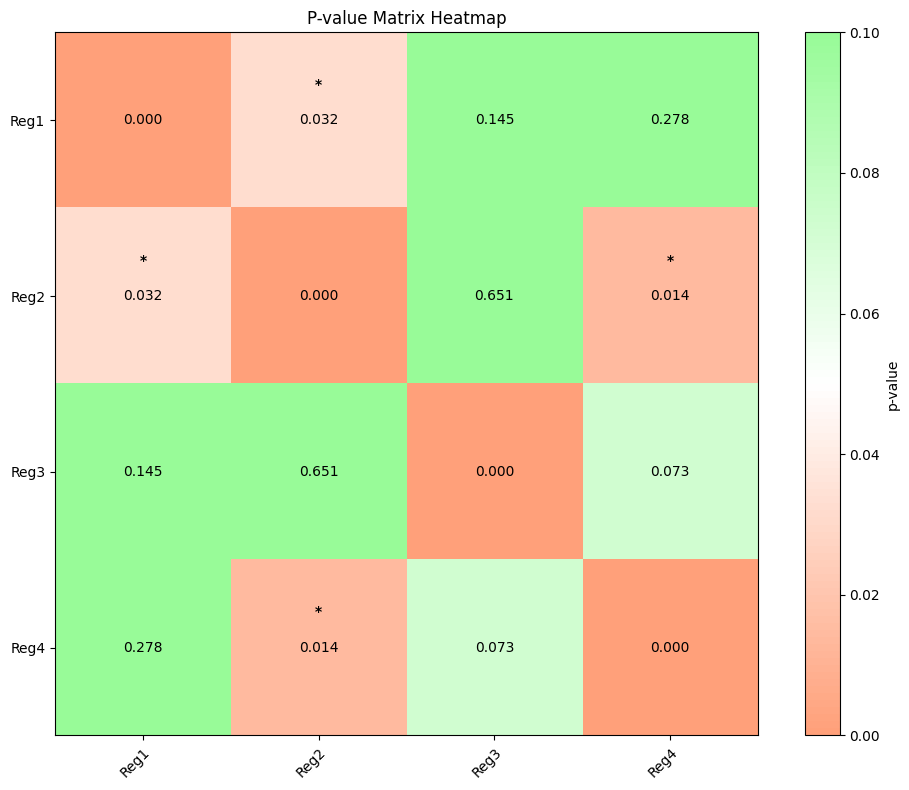

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def visualize_p_value_matrix(p_value_matrix, labels=None, alpha=0.05):
    n = len(p_value_matrix)
    
    # Create a custom colormap
    colors = ['#FFA07A', 'white', '#98FB98']  # Light red to white to light green
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the heatmap
    im = ax.imshow(p_value_matrix, cmap=cmap, vmin=0, vmax=0.1)
    
    # Add colorbar
    cbar = fig.colorbar(im)
    cbar.set_label('p-value')
    
    # Add labels
    if labels:
        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(n))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, f"{p_value_matrix[i, j]:.3f}",
                           ha="center", va="center", color="black")
            
            # Add star for significant values
            if p_value_matrix[i, j] < alpha and i != j:
                ax.text(j, i-0.2, '*', ha='center', va='center', color='black', fontweight='bold')

    # Set title and adjust layout
    ax.set_title("P-value Matrix Heatmap")
    fig.tight_layout()
    
    # Show the plot
    plt.show()

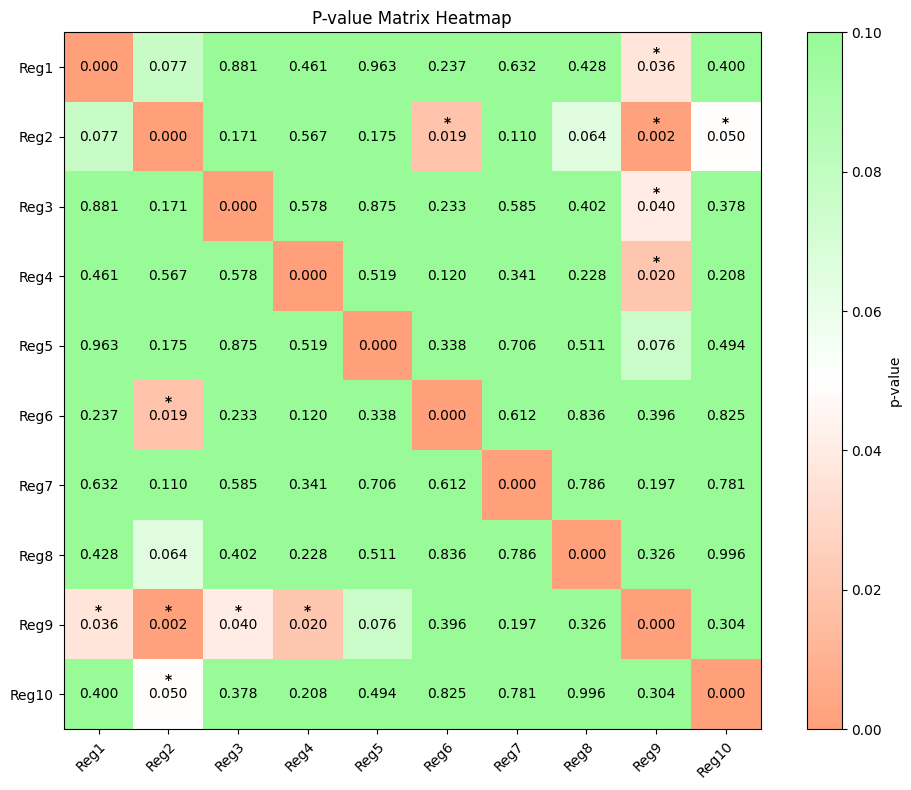

In [17]:
labels = ['Reg1', 'Reg2', 'Reg3', 'Reg4','Reg5', 'Reg6', 'Reg7', 'Reg8','Reg9', 'Reg10']
visualize_p_value_matrix(p_value_matrix, labels)

In [18]:
coef_se_list_2 = [
    (0.0279, 0.00640),  # (coefficient, standard error) for first regression
    (0.0216, 0.00844),  # for second regression
    (0.00818, 0.00989), # for third regression
    (0.0132, 0.0117),
    (0.00969, 0.0131),
    (0.0105, 0.0150),
    (0.0130, 0.0166),
    (0.0171, 0.0205),
    (-0.00503, 0.0232),
    (-0.0412, 0.0343)
]

chi_squared_matrix_2, p_value_matrix_2 = pairwise_chi_squared_matrix(coef_se_list_2)


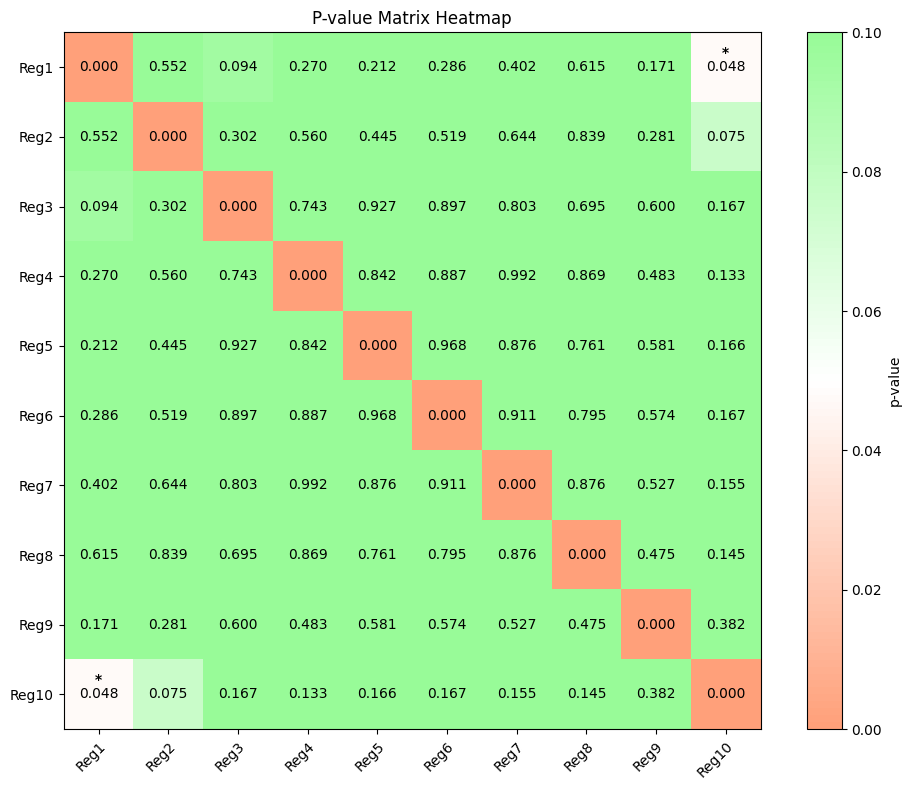

In [20]:
visualize_p_value_matrix(p_value_matrix_2, labels).

In [25]:
b12 = pd.read_stata('b12.dta')

In [26]:
before_12 = pd.read_stata('before_12.dta')

In [27]:
b12

,index,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,...,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te,publication_month_int,treatment_month_int,pubs_before_treatment_decile,months_before_treatment_decile
0,0,https://openalex.org/A5000001503,2021-01-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,175.850146,1,2,-0.311698,0,0,24253,24265,1,8
1,1,https://openalex.org/A5000001503,2021-02-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,175.850146,1,2,-0.311698,0,0,24254,24265,1,8
2,2,https://openalex.org/A5000001503,2021-03-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,175.850146,1,2,-0.311698,0,0,24255,24265,1,8
3,3,https://openalex.org/A5000001503,2021-04-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,175.850146,1,2,-0.311698,0,0,24256,24265,1,8
4,4,https://openalex.org/A5000001503,2021-05-01,0.0,0.0,0.0,2022-01-01,1,0,0,...,175.850146,1,2,-0.311698,0,0,24257,24265,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386131,386131,https://openalex.org/A5104977687,2023-07-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,105.850146,1,2,-0.395032,0,0,24283,24275,0,7
386132,386132,https://openalex.org/A5104977687,2023-08-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,105.850146,1,2,-0.395032,0,0,24284,24275,0,7
386133,386133,https://openalex.org/A5104977687,2023-09-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,105.850146,1,2,-0.395032,0,0,24285,24275,0,7
386134,386134,https://openalex.org/A5104977687,2023-10-01,0.0,0.0,0.0,2022-11-01,1,1,0,...,105.850146,1,2,-0.395032,0,0,24286,24275,0,7


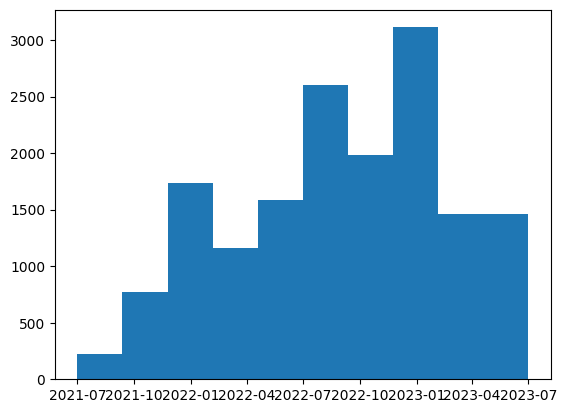

In [31]:
plt.hist(before_12['treatment_month'])
plt.show()

In [32]:
b12['count_12']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
386131    0.166667
386132    0.166667
386133    0.083333
386134    0.083333
386135    0.000000
Name: count_12, Length: 386136, dtype: float64

In [53]:
np.random.seed(1)
before_12['placebo_treatment'] = before_12['treatment_month'].sample(frac=1).reset_index()['treatment_month']

In [54]:
before_12[['treatment_month','placebo_treatment']]

,treatment_month,placebo_treatment
0,2022-01-01,2022-01-01
1,2022-12-01,2022-07-01
2,2023-06-01,2022-10-01
3,2022-09-01,2021-08-01
4,2022-04-01,2023-07-01
...,...,...
16084,2023-01-01,2022-08-01
16085,2022-09-01,2022-01-01
16086,2023-01-01,2023-03-01
16087,2023-02-01,2022-06-01


In [57]:
before_12['months_from_start']

0        419
1         93
2        244
3        498
4        287
        ... 
16084     35
16085    357
16086    506
16087    119
16088    349
Name: months_from_start, Length: 16089, dtype: int32

In [60]:
before_12['pre_obs']

0       -420
1        -94
2       -245
3       -499
4       -288
        ... 
16084    -36
16085   -358
16086   -507
16087   -120
16088   -350
Name: pre_obs, Length: 16089, dtype: int32

In [61]:
before_12['post_obs']

0        19
1        19
2        13
3        15
4        32
         ..
16084    23
16085    15
16086    20
16087    16
16088    19
Name: post_obs, Length: 16089, dtype: int32

In [62]:
df = pd.read_stata('alphafold_ls_24.dta')

In [63]:
df['months_from_treatment']

,index,id,publication_month,count,af_count,_2023_JIF_sum,_5_Year_JIF_sum,Immediacy_Index_sum,_2023_JCI_sum,Eigenfactor_sum,...,domain_hhi_adjusted_diff,months2,n,topics_hhi_12_adjusted,subfields_hhi_12_adjusted,fields_hhi_12_adjusted,domains_hhi_12_adjusted,average_2023_JIF,pubs_before_af,months_before_af
0,26628,https://openalex.org/A5000001503,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,156816.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,413.0
1,26629,https://openalex.org/A5000001503,2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,157609.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,413.0
2,26630,https://openalex.org/A5000001503,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,158404.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,413.0
3,26631,https://openalex.org/A5000001503,2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,159201.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,413.0
4,26632,https://openalex.org/A5000001503,2020-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,160000.0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,413.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420472,6995081,https://openalex.org/A5104992075,2022-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,58564.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,224.0
1420473,6995082,https://openalex.org/A5104992075,2023-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,59049.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,224.0
1420474,6995083,https://openalex.org/A5104992075,2023-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,59536.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,224.0
1420475,6995084,https://openalex.org/A5104992075,2023-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60025.0,0.0,NaN,NaN,NaN,NaN,NaN,6.0,224.0


In [64]:
obs = df.groupby('id')['months_from_treatment'].agg({'min','max'})

In [65]:
obs

,max,min
id,,
https://openalex.org/A5000001503,19,-24
https://openalex.org/A5000003497,-1,-24
https://openalex.org/A5000006031,-1,-24
https://openalex.org/A5000008953,-1,-24
https://openalex.org/A5000013516,20,1
...,...,...
https://openalex.org/A5104754401,-1,-24
https://openalex.org/A5104831610,6,-24
https://openalex.org/A5104831813,-1,-24


In [ ]:
df = pd.read_stata('alphafold_complete.dta')

In [ ]:
df

In [71]:
df[df['publication_month']==df['treatment_month']]

,id,publication_month,count,af_count,2023 JIF_sum,5 Year JIF_sum,Immediacy Index_sum,2023 JCI_sum,Eigenfactor_sum,Normalized Eigenfactor_sum,...,Article Influence Score_sum_12,authors_count_sum_3,authors_count_sum_6,authors_count_sum_12,countries_distinct_count_sum_3,countries_distinct_count_sum_6,countries_distinct_count_sum_12,institutions_distinct_count_sum_3,institutions_distinct_count_sum_6,institutions_distinct_count_sum_12
18611,https://openalex.org/A5000199400,2023-01-01,1.0,1.0,2.7,3.6,0.5,0.77,0.006,1.413,...,NaN,2.333333,NaN,NaN,0.333333,NaN,NaN,1.000000,NaN,NaN
9399,https://openalex.org/A5000096262,2022-01-01,2.0,1.0,7.3,7.4,2.5,1.97,0.038,8.317,...,0.190833,4.333333,2.166667,1.500000,1.000000,0.500000,0.333333,1.333333,0.666667,0.416667
14249,https://openalex.org/A5000141744,2023-09-01,1.0,1.0,4.0,4.9,0.9,1.20,0.048,10.536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18507,https://openalex.org/A5000198987,2023-12-01,1.0,1.0,11.0,14.5,1.2,2.47,0.065,14.125,...,1.176333,6.000000,3.000000,12.333333,0.333333,0.166667,0.666667,2.000000,1.000000,1.500000
28275,https://openalex.org/A5000311969,2023-05-01,1.0,1.0,7.8,8.0,1.2,1.86,0.005,1.099,...,1.133083,17.000000,8.500000,6.083333,2.333333,1.166667,0.916667,9.666667,4.833333,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587307,https://openalex.org/A5104955662,2023-07-01,1.0,1.0,4.4,3.7,0.8,0.66,0.011,2.470,...,0.839833,4.000000,2.000000,2.416667,1.666667,0.833333,0.500000,3.000000,1.500000,0.833333
9588461,https://openalex.org/A5104993318,2023-11-01,3.0,1.0,30.9,34.2,6.8,9.12,0.169,37.020,...,3.893083,750.333333,651.833333,456.250000,7.000000,5.666667,3.750000,14.000000,33.166667,24.833333
9588686,https://openalex.org/A5105003518,2023-06-01,2.0,1.0,10.9,12.1,1.9,2.34,0.246,53.753,...,6.905583,27.666667,24.500000,32.916667,2.666667,2.833333,5.166667,14.333333,11.333333,14.000000
9587864,https://openalex.org/A5104977541,2022-01-01,8.0,1.0,40.3,39.1,12.5,7.55,0.202,44.248,...,1.481167,105.666667,52.833333,28.833333,7.333333,3.666667,2.000000,59.000000,29.500000,15.083333


In [72]:
df['start_month']

18608     2022-10-01
18609     2022-10-01
18610     2022-10-01
18611     2022-10-01
18612     2022-10-01
             ...    
9588810   1900-01-01
9588811   1900-01-01
9588812   1900-01-01
9588813   1900-01-01
9588814   1900-01-01
Name: start_month, Length: 6995725, dtype: datetime64[ns]

In [4]:
df = pd.read_stata('b12.dta')

In [6]:
df = df.drop(columns={'index'})

In [7]:
df

,id,publication_month,count,af_count,_2023_JIF_sum,treatment_month,is_ls,is_ls_first,is_ls_last,start_month,...,months_before_treatment_demean,months_before_treatment_medsplit,months_before_treatment_tertile,productivity_before_treatment_de,productivity_before_treatment_me,productivity_before_treatment_te,publication_month_int,treatment_month_int,pubs_before_treatment_decile,months_before_treatment_decile
0,https://openalex.org/A5000001503,2021-01-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,175.850146,1,2,-0.311698,0,0,24253,24265,1,8
1,https://openalex.org/A5000001503,2021-02-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,175.850146,1,2,-0.311698,0,0,24254,24265,1,8
2,https://openalex.org/A5000001503,2021-03-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,175.850146,1,2,-0.311698,0,0,24255,24265,1,8
3,https://openalex.org/A5000001503,2021-04-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,175.850146,1,2,-0.311698,0,0,24256,24265,1,8
4,https://openalex.org/A5000001503,2021-05-01,0.0,0.0,0.0,2022-01-01,1,0,0,1987-01-01,...,175.850146,1,2,-0.311698,0,0,24257,24265,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386131,https://openalex.org/A5104977687,2023-07-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,105.850146,1,2,-0.395032,0,0,24283,24275,0,7
386132,https://openalex.org/A5104977687,2023-08-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,105.850146,1,2,-0.395032,0,0,24284,24275,0,7
386133,https://openalex.org/A5104977687,2023-09-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,105.850146,1,2,-0.395032,0,0,24285,24275,0,7
386134,https://openalex.org/A5104977687,2023-10-01,0.0,0.0,0.0,2022-11-01,1,1,0,1993-09-01,...,105.850146,1,2,-0.395032,0,0,24286,24275,0,7


In [13]:
desc_stats

,mean,std,min,max
count,0.486254,0.961497,0.0,20.00
_2023_JIF_sum,3.173165,9.322341,0.0,610.40
months_from_start,244.149854,139.389075,0.0,609.00
pubs_before_treatment,35.822674,41.351864,1.0,505.00
months_before_treatment,243.149854,139.194638,11.0,596.00
productivity_before_treatment,0.478365,0.602503,0.0,9.25


In [16]:
df.groupby('id')['months_before_treatment'].min()

id
https://openalex.org/A5000001503    419
https://openalex.org/A5000018755     93
https://openalex.org/A5000022218    244
https://openalex.org/A5000031273    498
https://openalex.org/A5000037407    287
                                   ... 
https://openalex.org/A5104336056     35
https://openalex.org/A5104355009    357
https://openalex.org/A5104385600    506
https://openalex.org/A5104670207    119
https://openalex.org/A5104977687    349
Name: months_before_treatment, Length: 16089, dtype: int32

In [23]:
df[df['months_before_treatment']==11]['id'].iloc[0]

'https://openalex.org/A5000449822'

In [21]:
df[df['months_before_treatment']==12]['id'].nunique()

34

In [25]:
df['months_before_treatment'] = df['months_before_treatment']+1

In [30]:
desc_stats = df[['count','_2023_JIF_sum','months_from_start','pubs_before_treatment','months_before_treatment','productivity_before_treatment']].describe().T[['mean', 'std', 'min', 'max']]

In [31]:
desc_stats

,mean,std,min,max
count,0.486254,0.961497,0.0,20.00
_2023_JIF_sum,3.173165,9.322341,0.0,610.40
months_from_start,244.149854,139.389075,0.0,609.00
pubs_before_treatment,35.822674,41.351864,1.0,505.00
months_before_treatment,244.149854,139.194638,12.0,597.00
productivity_before_treatment,0.478365,0.602503,0.0,9.25


In [32]:
correlations = df[['count','_2023_JIF_sum','months_from_start','pubs_before_treatment','months_before_treatment','productivity_before_treatment']].corr()

In [33]:
correlations

,count,_2023_JIF_sum,months_from_start,pubs_before_treatment,months_before_treatment,productivity_before_treatment
count,1.000000,0.649741,0.166133,0.521417,0.165825,0.577795
_2023_JIF_sum,0.649741,1.000000,0.110683,0.353332,0.109944,0.381121
months_from_start,0.166133,0.110683,1.000000,0.393408,0.998605,0.273553
pubs_before_treatment,0.521417,0.353332,0.393408,1.000000,0.393957,0.859111
months_before_treatment,0.165825,0.109944,0.998605,0.393957,1.000000,0.273935
productivity_before_treatment,0.577795,0.381121,0.273553,0.859111,0.273935,1.000000


In [34]:
combined_table = pd.concat([desc_stats, correlations], axis=1)

In [35]:
combined_table

,mean,std,min,max,count,_2023_JIF_sum,months_from_start,pubs_before_treatment,months_before_treatment,productivity_before_treatment
count,0.486254,0.961497,0.0,20.00,1.000000,0.649741,0.166133,0.521417,0.165825,0.577795
_2023_JIF_sum,3.173165,9.322341,0.0,610.40,0.649741,1.000000,0.110683,0.353332,0.109944,0.381121
months_from_start,244.149854,139.389075,0.0,609.00,0.166133,0.110683,1.000000,0.393408,0.998605,0.273553
pubs_before_treatment,35.822674,41.351864,1.0,505.00,0.521417,0.353332,0.393408,1.000000,0.393957,0.859111
months_before_treatment,244.149854,139.194638,12.0,597.00,0.165825,0.109944,0.998605,0.393957,1.000000,0.273935
productivity_before_treatment,0.478365,0.602503,0.0,9.25,0.577795,0.381121,0.273553,0.859111,0.273935,1.000000


In [36]:
table_text = combined_table.to_string()


In [38]:
print(table_text)

                                     mean         std   min     max     count  _2023_JIF_sum  months_from_start  pubs_before_treatment  months_before_treatment  productivity_before_treatment
count                            0.486254    0.961497   0.0   20.00  1.000000       0.649741           0.166133               0.521417                 0.165825                       0.577795
_2023_JIF_sum                    3.173165    9.322341   0.0  610.40  0.649741       1.000000           0.110683               0.353332                 0.109944                       0.381121
months_from_start              244.149854  139.389075   0.0  609.00  0.166133       0.110683           1.000000               0.393408                 0.998605                       0.273553
pubs_before_treatment           35.822674   41.351864   1.0  505.00  0.521417       0.353332           0.393408               1.000000                 0.393957                       0.859111
months_before_treatment        244.149854  13